In [4]:
#This header file contains all the common packages
%run header.ipynb

In [ ]:
phi_1d=np.load("/home/cz136/project/sa/data/{}/phi_1d.npy".format(dir_string))
phi_w_1d=np.load("/home/cz136/project/sa/data/{}/phi_1d.npy".format(dir_string))
e_list=np.load("/home/cz136/project/sa/data/{}/e_array.npy".format(dir_string))

In [5]:
print(len(clusters))
print(len(shapes))

3771
144119


In [6]:
def drop_poor_centers():
    """Drop clusters with no center shape data from the cluster dataframe"""
    center_id=clusters[('Alt', 'Alt1', 'ID_CENT')]
    pp=shapes.loc[center_id][('All','PP')].to_numpy()
    missing_mem_match_id=clusters[np.isnan(pp)].index
    clusters.drop(missing_mem_match_id,inplace=True)
    np.save("/home/cz136/project/sa/data/{}/missing_centers.npy".format(dir_string),center_id[np.isnan(pp)].to_numpy())
    print("The number of clusters with no center shape data {}".format(np.sum(np.isnan(pp))))
    print("The number of clusters with low probability center {}".format(np.sum(pp[~np.isnan(pp)]<=0.55)))
drop_poor_centers()

The number of clusters with no center shape data 0
The number of clusters with low probability center 2


In [7]:
# Print the numbers of galaxies that needed to be masked


print(np.sum(shapes[('All','e1')]==-9999))
print(np.sum(shapes[('All','e2')]==-9999))
print(np.sum(shapes['All','flags_select']==0))
print(np.sum(shapes[('All','PP')]<=0.55))

0
0
144119
54636


In [8]:
#masking


shapes=shapes[shapes[('All','PP')]>=0.55]
# shapes=shapes[shapes[('All','e1')]!=-9999]
# shapes=shapes[shapes[('All','e2')]!=-9999]
shapes=shapes[shapes[('All', 'flags_select')]==0]


print(len(clusters))
print(len(shapes))

3771
89483


# Stats of e1,e2

count    89483.000000
mean        -0.000681
std          0.150689
min         -0.693726
25%         -0.078243
50%         -0.000487
75%          0.076845
max          0.775665
Name: (All, e2), dtype: float64

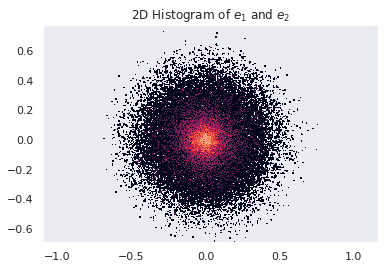

In [9]:
from matplotlib.colors import LogNorm 
plt.hist2d(shapes['All','e1'],shapes['All','e2'],bins=500,norm=LogNorm())
plt.axis('equal')
plt.title("2D Histogram of $e_1$ and $e_2$")
pd.Series(shapes['All','e1']).describe()
pd.Series(shapes['All','e2']).describe()

count    89483.000000
mean         2.203056
std        339.102193
min     -12001.081281
25%         -1.006389
50%          0.001150
75%          1.001855
max      67310.028672
dtype: float64

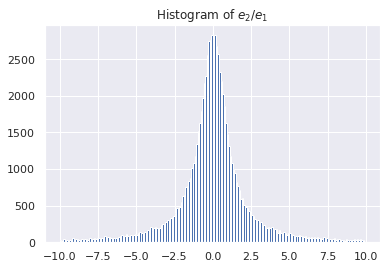

In [10]:
#statistics and hisgoram of e2/e1
plt.hist(shapes['All','e2']/shapes['All','e1'],bins=np.arange(-10,10,0.1))
plt.title("Histogram of $e_2$/$e_1$")
pd.Series(shapes['All','e2']/shapes['All','e1']).describe()

# Get phi 

In [11]:
def get_std_err_of_mean(np_array):
    mean=np_array.mean()
    std=np_array.std()
    n=len(np_array)
    return(std/np.sqrt(n))

In [12]:
def get_theta_for_obj(obj1,obj2):
    
    """Theta is the position angle of obj2 from north of east of obj1 """
    
    ra1,dec1=(obj1[('All', 'RA')],obj1[('All', 'DEC')])
    ra2,dec2=(obj2[('All', 'RA')],obj2[('All', 'DEC')])
    
    
    
    c1=SkyCoord(ra1*u.deg,dec1*u.deg)
    c2=SkyCoord(ra2*u.deg,dec2*u.deg)
    
    
    return(90-c1.position_angle(c2).degree)
    

In [13]:
def get_pa_for_obj(obj):
    e1=obj['All']['e1']
    e2=obj['All']['e1']
    
    α =0.5*np.arctan2(-e2,-e1)*180/np.pi
    return(α)

In [14]:
error_list_phi=[]
error_list_e=[]

def get_phi_for_cluster(cluster):
    
    """Input: cluster series
        Output: an array of position angle weighted by PP
        Record KeyError in an array (usually caused by uncomplete shape catalog).
    """
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]



        pa=np.array([get_pa_for_obj(member[1]) for member in members.iterrows()]).flatten()
        theta= np.array([get_theta_for_obj(member[1],center) for member in members.iterrows()]).flatten()
        pp=members[('All','PP')]
        phi=(pa-theta)
        phi_w=(pa-theta)*pp
    #     print(center.index)
        return(phi,phi_w)    
    except KeyError as e:
        error_list_phi.append(e)
        return(np.array([]),np.array([]))

In [15]:
phi_list=[]
phi_w_list=[]
for mem_matching_id in tqdm(clusters.index):
    phi_array=get_phi_for_cluster(clusters.loc[mem_matching_id])[0]
    phi_w_array=get_phi_for_cluster(clusters.loc[mem_matching_id])[1]
    phi_w_list.append(phi_w_array)
    phi_list.append(phi_array)
phi_list=np.array(phi_list)
phi_w_list=np.array(phi_w_list)

In [16]:
def process_phi(phi_list):

    phi_1d=np.concatenate(phi_list)

    phi_1d=np.where(phi_1d<=0,-phi_1d,phi_1d)
    phi_1d=np.where(phi_1d>=180,phi_1d-180,phi_1d)
    phi_1d=np.where(phi_1d>=90,180-phi_1d,phi_1d)

    phi_1d=np.sort(phi_1d)
    
    return(phi_1d)

phi_1d=process_phi(phi_list)
phi_w_1d=process_phi(phi_w_list)

In [17]:
np.save("/home/cz136/project/sa/data/{}/phi_1d.npy".format(dir_string),phi_1d)
np.save("/home/cz136/project/sa/data/{}/phi_w_1d.npy".format(dir_string),phi_w_1d)

## Stats for unweighted 

In [18]:
# phi_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
pd.Series(phi_1d).describe()
print("Mean:{:05e} \nStdE:{:05e} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

Mean:4.523709e+01 
StdE:8.615106e-02 


count    89474.000000
mean        45.237093
std         25.769827
min          0.003257
25%         22.500000
50%         45.328180
75%         67.500000
max         89.998205
dtype: float64

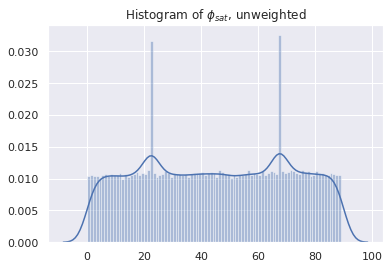

In [19]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $\phi_{sat}$, unweighted") 
pd.Series(phi_1d).describe()

## Stats for weighted

In [20]:
pd.Series(phi_w_1d).describe()
print("Mean:{:05e} \nStdE:{:05e} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

Mean:4.523709e+01 
StdE:8.615106e-02 


count    89474.000000
mean        45.039924
std         25.798344
min          0.000228
25%         22.500000
50%         44.898001
75%         67.500000
max         89.998497
dtype: float64

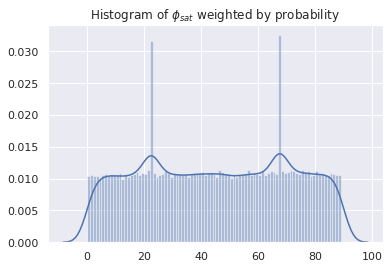

In [21]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $\phi_{sat}$ weighted by probability") 
pd.Series(phi_w_1d).describe()

# Analysis around 22.5 and 67.5

In [22]:
#Print out the most crowded bins

phi_count=np.histogram(phi_1d,bins=BINS)
sort=np.argsort(-phi_count[0])
print(phi_count[1][sort])
print(phi_count[0][sort])

[67 22 46 71 75 56 21 27 68 61 64 80 72 77 17 43 47 70 65 40 76 19 38 73
 30 69 39 37 82 28 58 23 85 42 11 81 63 44  8 48 34 59 16 86 55  6 74 66
 36 31 49 26 20 32 13 15  5 57  1 60 62 88 54 51 25 84 41 18 87 33 10 53
 83  9 79 78  2  0  7  3 24 29 45 35 52 14 50  4 12]
[2882 2806 1013 1006 1005 1003 1002  998  998  994  993  993  990  987
  984  984  979  979  976  974  973  971  971  970  970  969  967  967
  966  965  964  962  961  960  960  959  959  958  957  956  954  954
  954  953  952  952  951  951  951  948  947  947  945  944  944  943
  942  942  940  939  938  938  938  936  936  935  935  935  934  934
  934  932  931  931  930  929  925  923  920  916  915  913  913  909
  907  907  895  892  878]


count    2882.000000
mean       22.515034
std         0.186319
min        22.001519
25%        22.500000
50%        22.500000
75%        22.500000
max        23.080021
dtype: float64

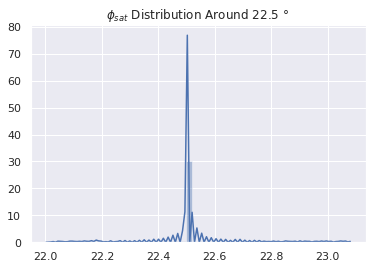

In [23]:
#Statistics around 22.5
first_cluster_left=np.sum(phi_count[0][0:22])
first_length=phi_count[0][sort][0]
first_cluster=phi_1d[first_cluster_left:first_cluster_left+first_length]
ax = sns.distplot(first_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 22.5 $\degree$")
pd.Series(first_cluster).describe()

count    2882.000000
mean       67.503040
std         0.167697
min        67.000614
25%        67.500000
50%        67.500000
75%        67.500000
max        67.999551
dtype: float64

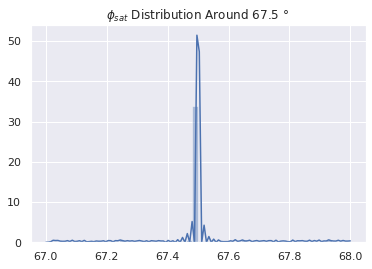

In [24]:
second_cluster_left=np.sum(phi_count[0][0:67])
second_length=phi_count[0][sort][0]
second_cluster=phi_1d[second_cluster_left:second_cluster_left+second_length]
ax = sns.distplot(second_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 67.5 $\degree$")
pd.Series(second_cluster).describe()

# Get e

## Statistics of e1 and e2

In [25]:
e1=shapes[('All','e1')].to_numpy()
shapes[('All','e1')].describe()

count    89483.000000
mean        -0.000079
std          0.150188
min         -0.687860
25%         -0.076607
50%         -0.000321
75%          0.076502
max          0.756333
Name: (All, e1), dtype: float64

In [26]:
e2=shapes[('All','e1')].to_numpy()
shapes[('All','e2')].describe()

count    89483.000000
mean        -0.000681
std          0.150689
min         -0.693726
25%         -0.078243
50%         -0.000487
75%          0.076845
max          0.775665
Name: (All, e2), dtype: float64

In [27]:
def get_e_for_pair(cen,sat):
    e=np.sqrt(sat[('All','e1')]**2+sat[('All','e2')]**2)
    delta=get_theta_for_obj(cen,sat)
    alpha=get_pa_for_obj(sat)
    ep,ex=(e*np.cos(2*(delta-alpha)),e*np.sin(2*(delta-alpha)))
    return(ep,ex)

In [28]:
def get_e_for_cluster(cluster):
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]

        e_array=np.array([(get_e_for_pair(center,member[1])) for member in members.iterrows()])
        return(e_array)    
    except KeyError as e:
        error_list_e.append(e)
        return(np.array([]))

In [29]:
e_list=[]
for mem_matching_id in tqdm(clusters.index[:]):
    e_array=get_e_for_cluster(clusters.loc[mem_matching_id])
    e_list.append(e_array)
e_list=np.array(e_list)
e_list=np.concatenate([e_array for e_array in e_list if e_array!=np.array([])])

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


In [30]:
np.save("/home/cz136/project/sa/data/{}/e_array".format(dir_string),e_list)

In [31]:
e_p_1d=e_list[:,0].flatten()
e_x_1d=e_list[:,1].flatten()

mean=-7.612042e-04, std_mean=5.048804e-04


count    89474.000000
mean        -0.000761
std          0.151022
min         -0.705929
25%         -0.080033
50%         -0.000385
75%          0.077548
max          0.683721
dtype: float64

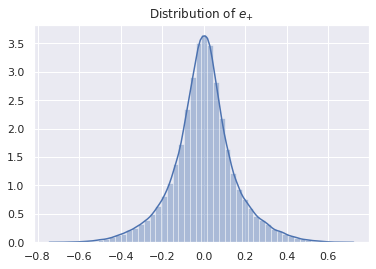

In [32]:
ax=sns.distplot(e_p_1d)
ax.set_title("Distribution of $e_{+}$")
print ("mean={:05e}, std_mean={:05e}".format(e_p_1d.mean(),get_std_err_of_mean(e_p_1d)))
pd.Series(e_p_1d).describe()

mean=1.764277e-03, std_mean=5.009093e-04


count    89474.000000
mean         0.001764
std          0.149834
min         -0.750668
25%         -0.074119
50%          0.004397
75%          0.077838
max          0.766395
dtype: float64

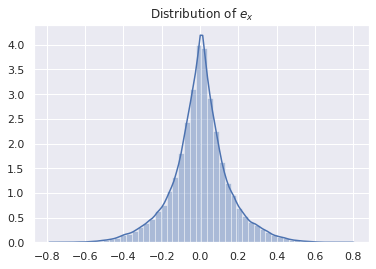

In [33]:
ax=sns.distplot(e_x_1d)
ax.set_title("Distribution of $e_{x}$")
print ("mean={:05e}, std_mean={:05e}".format(e_x_1d.mean(),get_std_err_of_mean(e_x_1d)))
pd.Series(e_x_1d).describe()